In [2]:
from tqdm.notebook import tqdm
import pandas as pd

In [3]:
%config InlineBackend.figure_format='retina'

In [159]:
import numpy as np
from scipy import sparse
from tqdm import tqdm

In [5]:
from p_tqdm import p_map, p_umap

In [6]:
!ls ../data/processed

APIs.csv	   A_tr.npz	     B_tr.npz	     meta_tr.csv       P_tr.npz
A_reduced_tr.npz   A_tst.npz	     counts_tr.npz   meta_tst.csv      walks
A_reduced_tst.npz  B_reduced_tr.npz  counts_tst.npz  P_reduced_tr.npz


## Gensim

In [8]:
!ls ../data/processed/walks -al

total 95767
drwxr-xr-x 2 yuz530 root        7 May 12 19:08  .
drwxrwxrwx 3 yuz530 root       16 May 12 23:29  ..
-rw-r--r-- 1 yuz530 root 62182673 May 12 09:47 'node2vec_n=100_p=2_q=1_wl=60.cor'
-rw-r--r-- 1 yuz530 root  9331298 May 12 19:43 'node2vec_n=15_p=2_q=1_wl=60.cor'
-rw-r--r-- 1 yuz530 root 62204045 May 12 09:52 'node2vec_n=200_p=2_q=1_wl=30.cor'
-rw-r--r-- 1 yuz530 root 62164085 May 12 09:53 'node2vec_n=20_p=2_q=1_wl=300.cor'
-rw-r--r-- 1 yuz530 root        0 May 12 19:08 'node2vec_n=30_p=2_q=1_wl=60.cor'


In [160]:
CORPUS = '../data/processed/walks/node2vec_n=15_p=2_q=1_wl=60.cor'

In [165]:
from gensim import utils

class MyCorpus(object):
    """An interator that yields sentences (lists of str)."""
    def __init__(self, corpus_path):
        self.lines = open(corpus_path).readlines()

    def __iter__(self):
        corpus_path = CORPUS
        for line in tqdm(self.lines):
            # assume there's one document per line, tokens separated by whitespace
            yield line.strip().split(' ')

In [168]:
sentences = MyCorpus(CORPUS)

In [169]:
import gensim.models

In [171]:
%%time
model = gensim.models.Word2Vec(
    sentences=sentences, size=64, sg=1, 
    negative=5, window=3, iter=10, min_count=1
)

100%|██████████| 20025/20025 [00:03<00:00, 5847.78it/s]


CPU times: user 1min 52s, sys: 507 ms, total: 1min 53s
Wall time: 38.4 s


In [144]:
!ls ../data/processed/ -al

total 101086
drwxrwxrwx 3 yuz530 root       16 May 12 23:29 .
drwxr-xr-x 6 yuz530 root        6 May  4 11:30 ..
-rw-r--r-- 1 yuz530 root 49473520 May 12 01:51 APIs.csv
-rw-r--r-- 1 yuz530 root    97138 May 12 23:27 A_reduced_tr.npz
-rw-r--r-- 1 yuz530 root    96574 May 12 23:27 A_reduced_tst.npz
-rwxrwxrwx 1 yuz530 root 19279492 May 12 02:14 A_tr.npz
-rwxrwxrwx 1 yuz530 root 18439752 May 12 02:14 A_tst.npz
-rw-r--r-- 1 yuz530 root    47870 May 12 23:27 B_reduced_tr.npz
-rwxrwxrwx 1 yuz530 root 33589692 May 12 02:15 B_tr.npz
-rwxrwxrwx 1 yuz530 root 23996409 May 12 02:14 counts_tr.npz
-rwxrwxrwx 1 yuz530 root 22947615 May 12 02:15 counts_tst.npz
-rwxrwxrwx 1 yuz530 root   149373 May 12 03:10 meta_tr.csv
-rwxrwxrwx 1 yuz530 root   150425 May 12 03:10 meta_tst.csv
-rw-r--r-- 1 yuz530 root     5397 May 12 23:27 P_reduced_tr.npz
-rwxrwxrwx 1 yuz530 root  6491148 May 12 02:15 P_tr.npz
drwxr-xr-x 2 yuz530 root        7 May 12 19:08 walks


In [145]:
meta_tr = pd.read_csv('../data/processed/meta_tr.csv', index_col=0)

In [146]:
meta_tr.head()

,label,package,csv_path,AA,APA,ABA,APBPA,ABPBA
app_0,class1,157517784ed9b575846864aa3f39b3d7,data/interim/class1/157517784ed9b575846864aa3f...,1,1,1,1,1
app_1,class0,com.app.kilani_jobs,data/interim/class0/com.app.kilani_jobs.csv,0,0,0,0,0
app_2,class0,com.andromo.dev513556.app479954,data/interim/class0/com.andromo.dev513556.app4...,0,0,0,0,0
app_3,class1,b1cbf04952bc232b6484bccf0bbf7d36,data/interim/class1/b1cbf04952bc232b6484bccf0b...,1,1,1,1,1
app_4,class0,com.easyemerge.emergeeverywhere.android,data/interim/class0/com.easyemerge.emergeevery...,0,0,0,0,0


In [147]:
y_train = meta_tr.label == 'class1'

In [148]:
app_vec = np.array([model.wv[f'app_{i}'] for i in range(len(meta_tr))])

In [149]:
from sklearn.svm import SVC
svm = SVC(kernel='linear')

In [150]:
svm.fit(app_vec, y_train)

SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='linear',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

In [151]:
svm.score(app_vec, y_train)

0.9827715355805243

In [152]:
svm.score(app_vec, y_train)

0.9827715355805243

In [153]:
!head ../data/processed/meta_tr.csv

,label,package,csv_path,AA,APA,ABA,APBPA,ABPBA
app_0,class1,157517784ed9b575846864aa3f39b3d7,data/interim/class1/157517784ed9b575846864aa3f39b3d7.csv,1,1,1,1,1
app_1,class0,com.app.kilani_jobs,data/interim/class0/com.app.kilani_jobs.csv,0,0,0,0,0
app_2,class0,com.andromo.dev513556.app479954,data/interim/class0/com.andromo.dev513556.app479954.csv,0,0,0,0,0
app_3,class1,b1cbf04952bc232b6484bccf0bbf7d36,data/interim/class1/b1cbf04952bc232b6484bccf0bbf7d36.csv,1,1,1,1,1
app_4,class0,com.easyemerge.emergeeverywhere.android,data/interim/class0/com.easyemerge.emergeeverywhere.android.csv,0,0,0,0,0
app_5,class0,io.westviewapp.official,data/interim/class0/io.westviewapp.official.csv,0,0,0,0,0
app_6,class0,com.conduit.app_f1cce681dece40e88f48fab0345c8f8c.app,data/interim/class0/com.conduit.app_f1cce681dece40e88f48fab0345c8f8c.app.csv,0,0,0,1,0
app_7,class0,com.sparrowworld.gujaratinglish,data/interim/class0/com.sparrowworld.gujaratinglish.csv,0,0,0,0,0
app_8,class1,509436e0d4fb98a6ef646a70019337

In [154]:
!ls ../data/processed/

APIs.csv	   A_tr.npz	     B_tr.npz	     meta_tr.csv       P_tr.npz
A_reduced_tr.npz   A_tst.npz	     counts_tr.npz   meta_tst.csv      walks
A_reduced_tst.npz  B_reduced_tr.npz  counts_tst.npz  P_reduced_tr.npz


In [155]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
%matplotlib inline

In [156]:
def tsne_plot(model):
    "Creates and TSNE model and plots it"
    embs = {}

    for word in model.wv.vocab:
        if 'api' in word: continue
        embs[word] = model.wv[word]
    
    tsne_model = TSNE(n_components=2, random_state=0)
    new_values = tsne_model.fit_transform(list(embs.values()))

    token_coor = dict(zip(embs.keys(), new_values))

    plt.figure(figsize=(16, 12))
    cycle = plt.rcParams['axes.prop_cycle'].by_key()['color']

    for token, coor in token_coor.items():
        x, y = coor
        label = meta_tr[meta_tr.app_id == token].label.item()
        color = cycle[0] if label == 'class1' else cycle[1]
        plt.scatter(x, y, c=color, alpha=0.8)
# #         plt.annotate(labels[i],
# #                      xy=(x[i], y[i]),
# #                      xytext=(5, 2),
# #                      textcoords='offset points',
# #                      ha='right',
# #                      va='bottom')
    plt.show()

In [157]:
meta_tr['app_id'] = [f'app_{i}' for i in range(meta_tr.shape[0])]

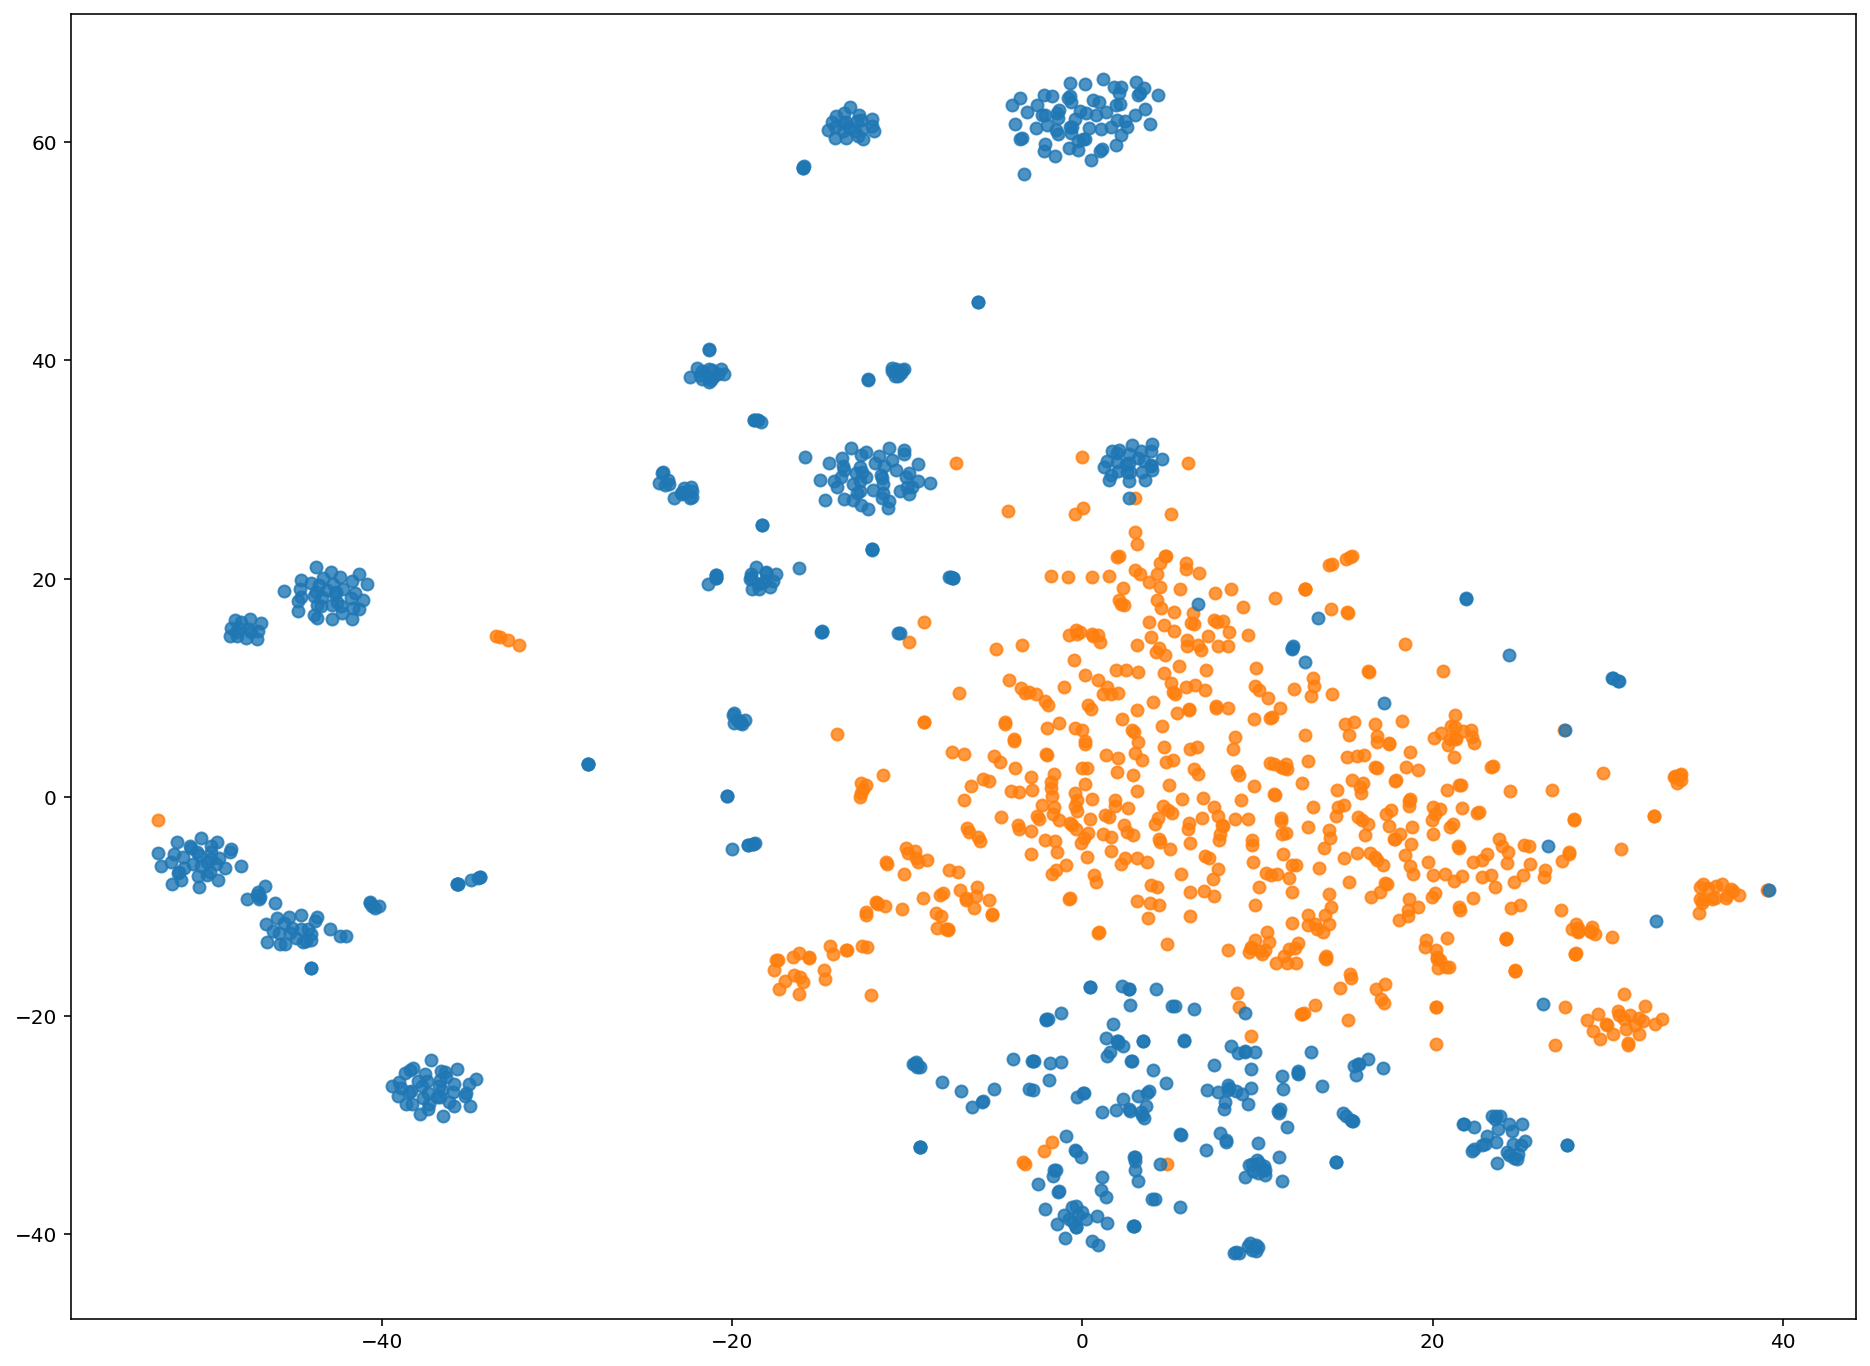

In [158]:
tsne_plot(model)

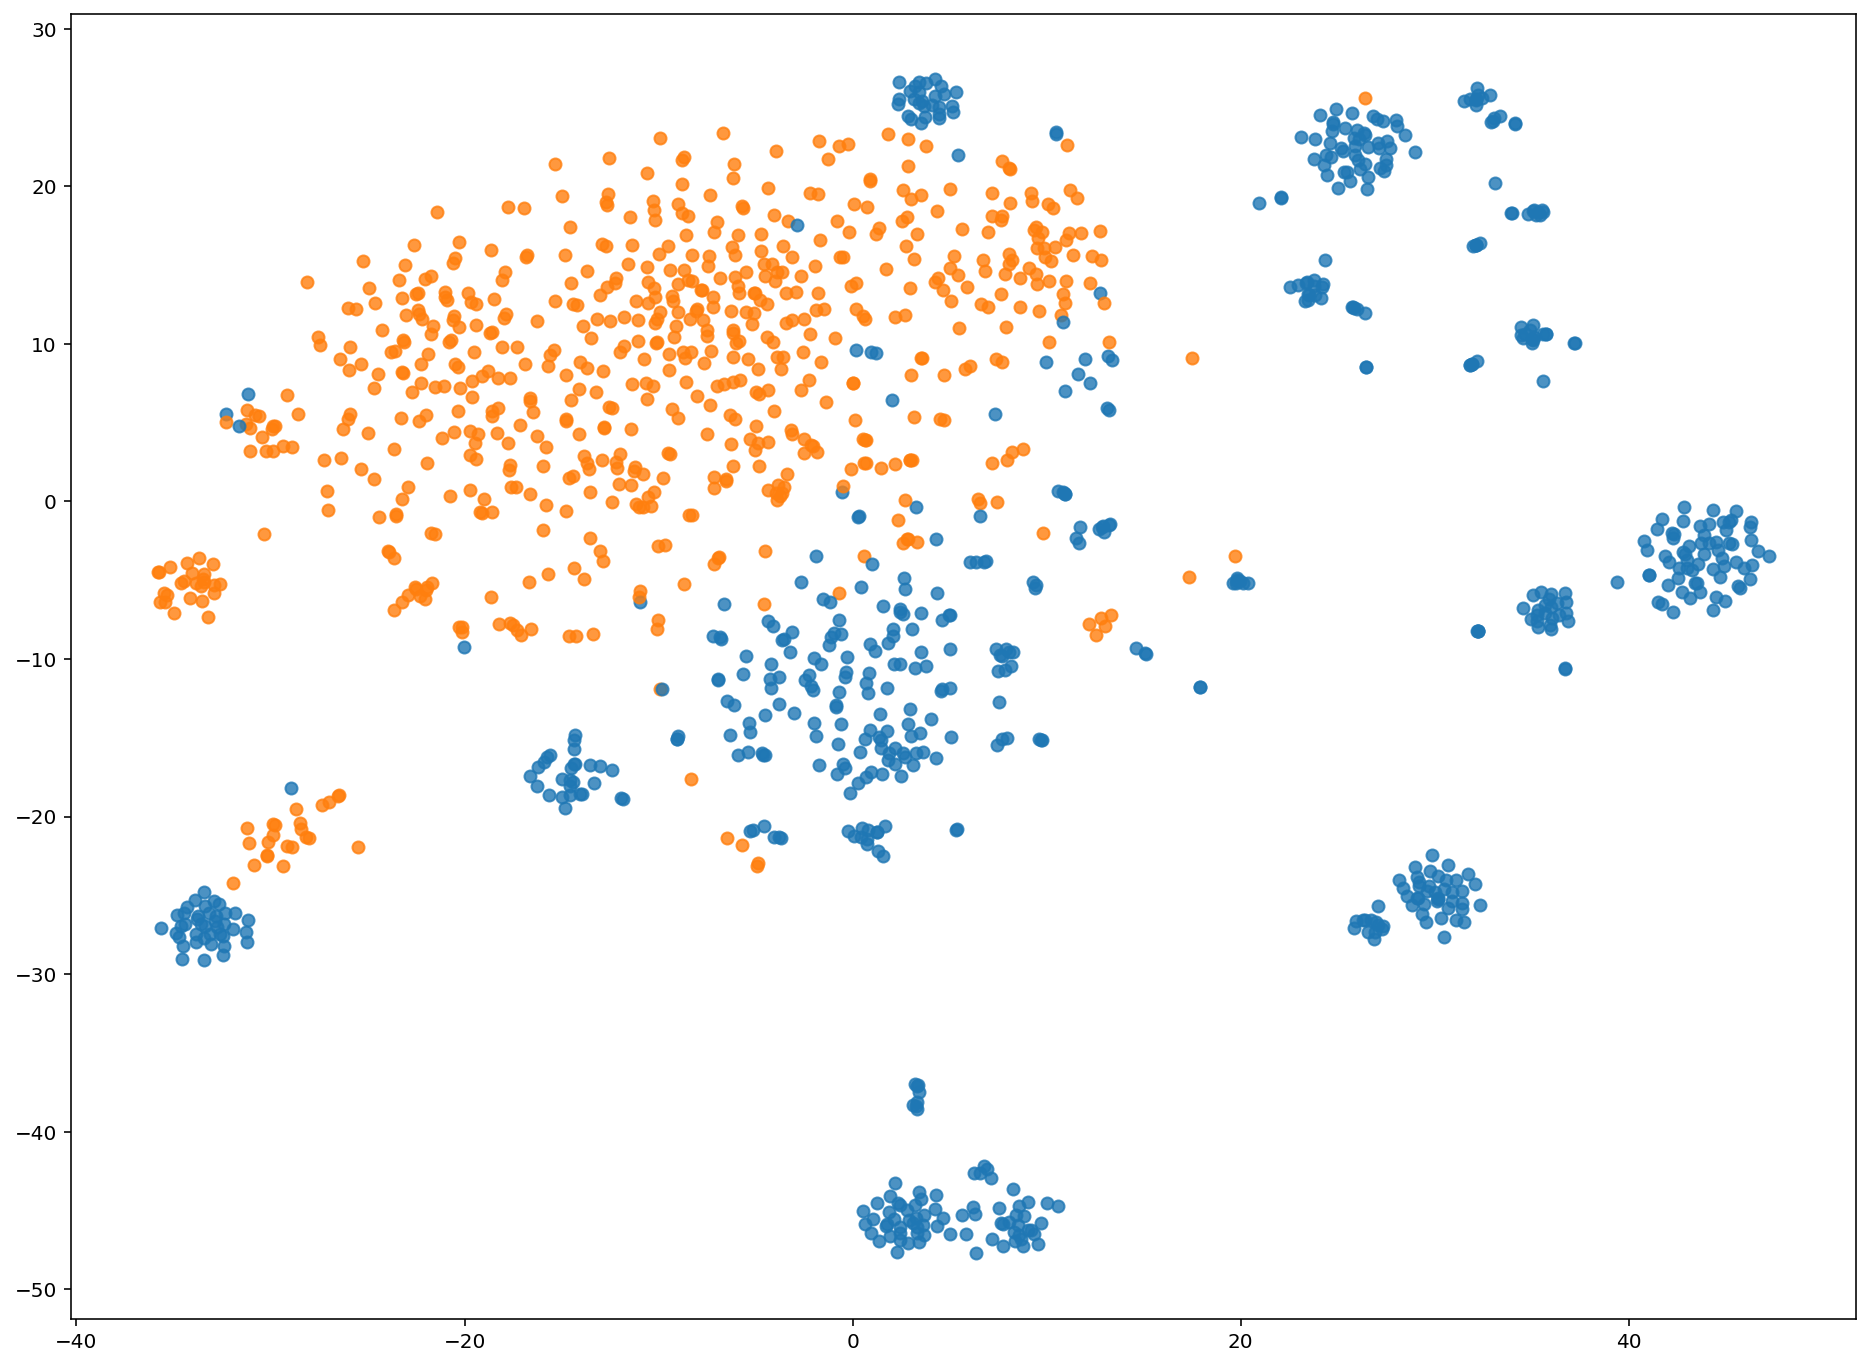

In [176]:
tsne_plot(model)

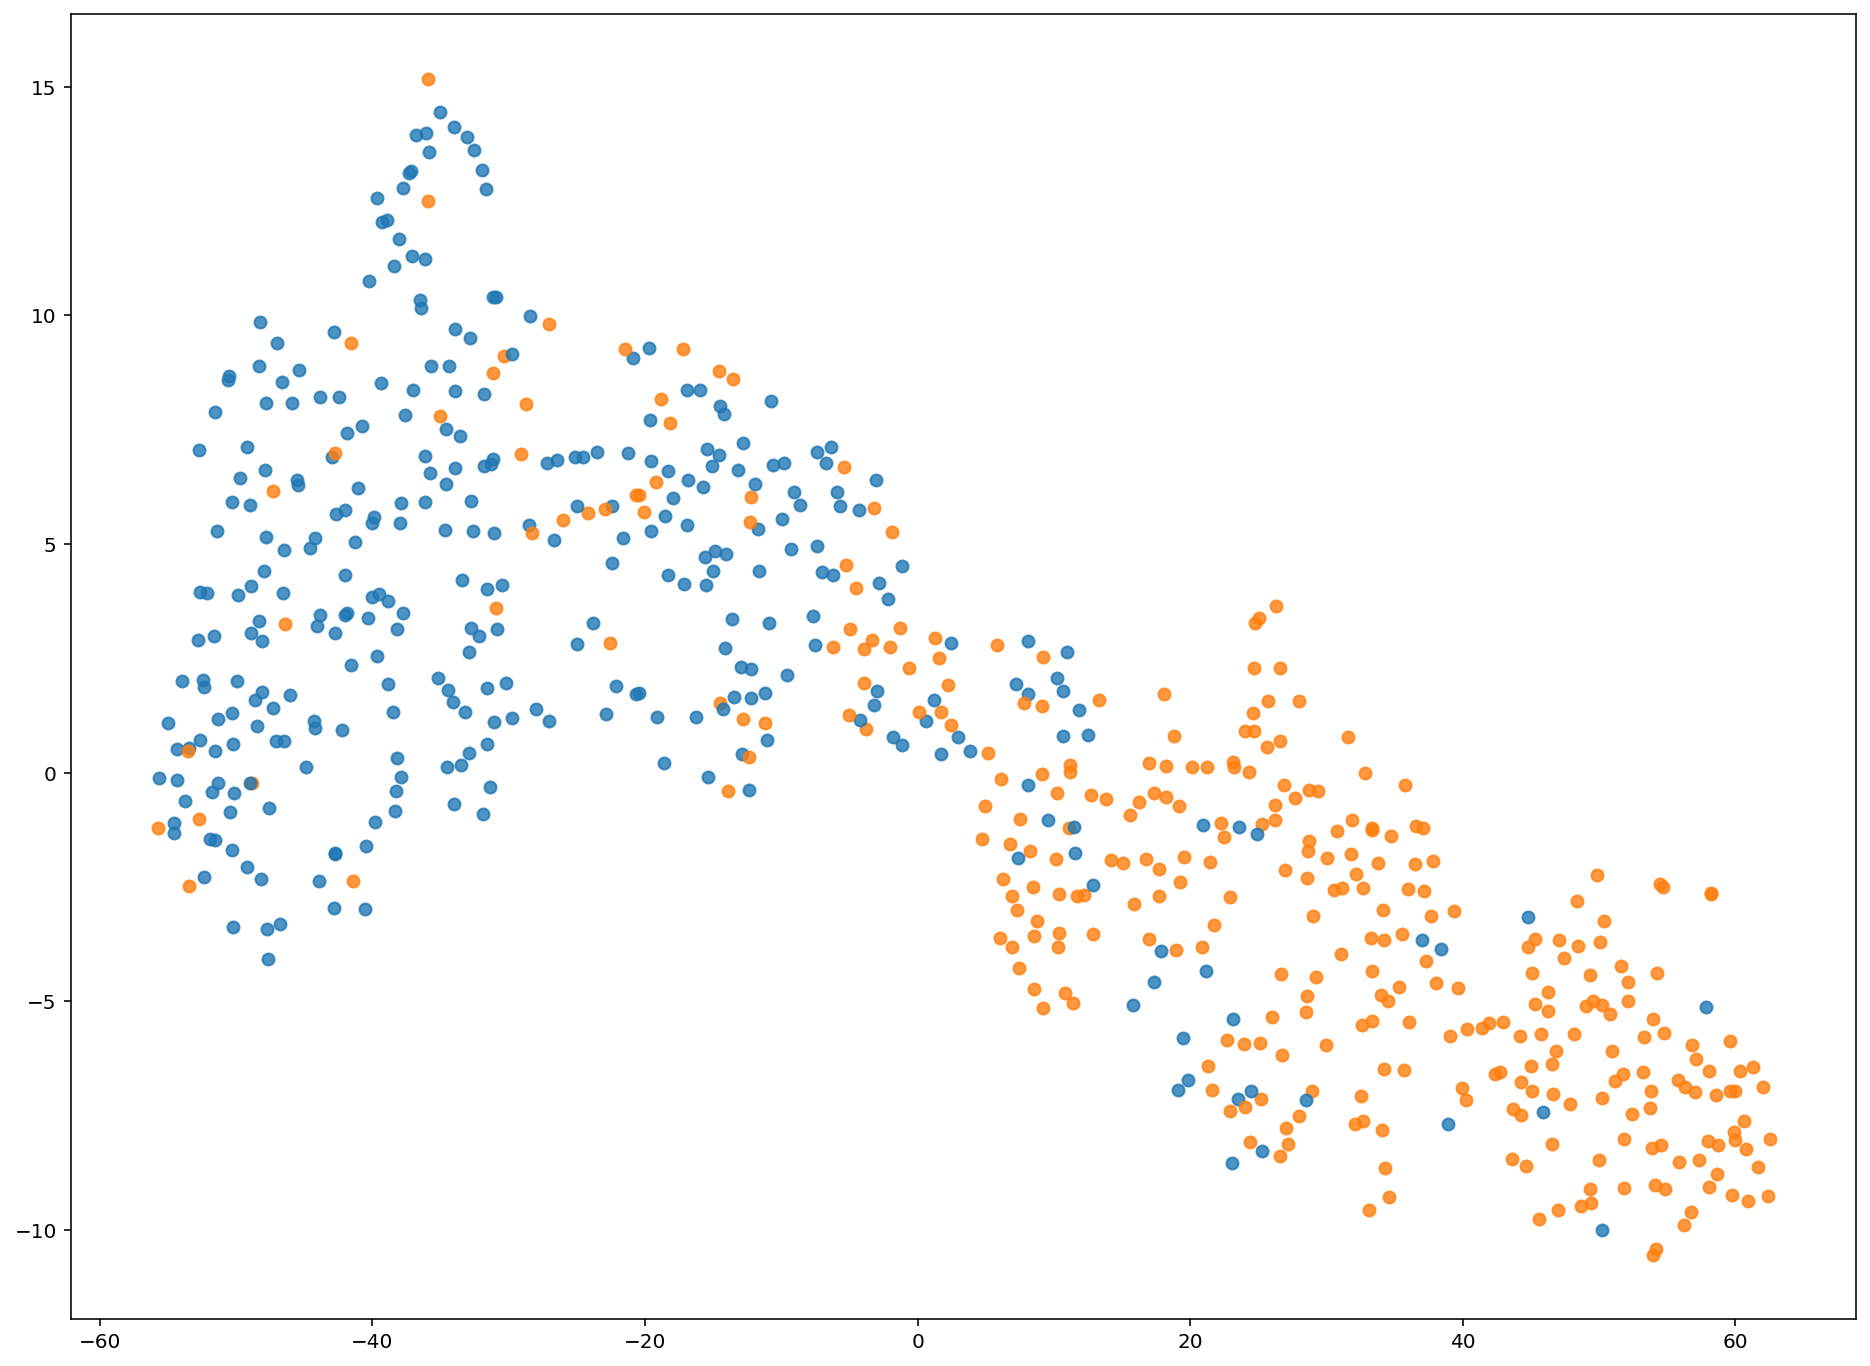

In [29]:
tsne_plot(model)
# node2vec_n=10_p=2_q=1_wl=100.cor

In [173]:
from sklearn.model_selection import train_test_split

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(bm_)

In [172]:
app_vec = 

array([[-0.29679388,  0.7541804 , -0.50717384, ..., -0.33132794,
         0.859155  ,  0.45515087],
       [-0.05652858, -0.24979568, -0.33929825, ...,  0.20293018,
         0.19647716, -0.4679515 ],
       [-0.43622985, -0.06490188,  0.18360992, ...,  0.1295357 ,
        -0.19520085,  0.21368966],
       ...,
       [-0.14056242, -0.20460042, -0.18953854, ..., -0.05658302,
        -0.35678035,  0.1322565 ],
       [-0.19690552, -0.4971275 , -0.3148198 , ...,  0.25434524,
        -0.21417353,  0.00400952],
       [ 0.11623956, -0.8221772 , -0.3550009 , ..., -0.26313967,
        -0.41599858, -0.0481328 ]], dtype=float32)